Parameter-based aggregation

Aggregator : Weighted FedAvg

Weighting factor = relative data size per client

Client’s local data size over total data size

McMahan et al., 2017

In [1]:
# Import Libraries
!pip install tensorflow tensorflow-datasets matplotlib
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import gc
from tensorflow.keras import backend as K
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.regularizers import l2
from collections import Counter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 139.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 155.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 169.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 166.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 3.8 MB/s eta 0:00:00


Memory Management Function

In [2]:
# Function to clear TensorFlow memory and handle GPU memory growth
def clear_tf_memory():
    K.clear_session()  # Clear the current TensorFlow session
    gc.collect()  # Force garbage collection to release unreferenced memory
    if tf.config.list_physical_devices('GPU'):  # Check if GPUs are available
        for gpu in tf.config.list_physical_devices('GPU'):  # Iterate over each GPU
            tf.config.experimental.set_memory_growth(gpu, True)  # Enable dynamic memory growth for the GPU
            # This prevents TensorFlow from allocating all GPU memory at once

clear_tf_memory()  # Call the function to clear memory at the start

Define Global Variables and Data Augmentation

In [3]:
# Define global variables for the federated learning setup
dataset_name = 'tf_flowers'  # Name of the dataset to use
batch_size = 32  # Batch size for training
img_height = 224  # Height of the input images
img_width = 224  # Width of the input images
num_rounds = 15  # Number of communication rounds in federated learning
epochs_per_client = 5  # Number of training epochs each client performs in each round
num_clients = 3  # Number of clients in the federated learning system
test_split = 0.1  # Fraction of the total training data to use as the global test set
local_val_split = 0.2  # Fraction of each client's data to use for local validation

# Enable mixed precision for better performance and reduced memory usage
policy = tf.keras.mixed_precision.Policy('mixed_float16')  # Define the mixed precision policy
tf.keras.mixed_precision.set_global_policy(policy)  # Set the global mixed precision policy

# Define data augmentation as a Keras Sequential model
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),  # Randomly flip images horizontally and vertically
    RandomRotation(0.2),  # Randomly rotate images by up to 20%
    RandomZoom(0.2),  # Randomly zoom in on images by up to 20%
    layers.RandomContrast(0.1),  # Randomly adjust contrast
], name="data_augmentation")  # Name the data augmentation layer

Load and Preprocess Dataset

In [4]:
# Load the TensorFlow Flowers dataset, splitting it into training and validation sets
(raw_train, raw_val), ds_info = tfds.load(
    dataset_name,  # Specify the dataset name
    split=['train[:80%]', 'train[80%:]'],  # Split the training set into 80% for training and 20% for validation
    as_supervised=True,  # Load the data as (image, label) pairs
    with_info=True  # Load additional information about the dataset
)

# Define a function to preprocess images
def preprocess(image, label):
    image = tf.image.resize(image, (img_height, img_width))  # Resize images to the desired height and width
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)  # Preprocess images for MobileNetV2
    return image, label  # Return the preprocessed image and its label

# Prepare the global validation set by preprocessing and batching the data
val_data = raw_val.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.S371UJ_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


Function to Create Client Datasets

In [5]:
# Function to create client datasets with local training and validation sets, and a global test set
def create_client_datasets(dataset, num_clients, local_val_split, test_split):
    # Shuffle the input dataset
    shuffled_dataset = dataset.shuffle(buffer_size=tf.data.experimental.cardinality(dataset).numpy(), seed=42)
    dataset_size = tf.data.experimental.cardinality(shuffled_dataset).numpy()  # get the size of the dataset

    # Split off the global test set
    test_size = int(test_split * dataset_size)  # Calculate the size of the test set
    global_test_dataset = shuffled_dataset.take(test_size)  # Extract the test set
    remaining_dataset = shuffled_dataset.skip(test_size)  # Get the remaining data after removing the test set

    # Split the remaining data into client datasets
    client_datasets = [
        remaining_dataset.shard(num_shards=num_clients, index=i) for i in range(num_clients)
    ]

    processed_client_datasets = []
    for client_data in client_datasets:
        # Resize the images
        client_data = client_data.map(lambda x, y: (tf.image.resize(x, (img_height, img_width)), y),
                                     num_parallel_calls=tf.data.AUTOTUNE)

        # Calculate the size of the local validation set for the current client.
        client_dataset_size = tf.data.experimental.cardinality(client_data).numpy()
        local_val_size = int(local_val_split * client_dataset_size)

        # Split the client data into local training and validation sets
        local_val_dataset = client_data.take(local_val_size)  # Extract the local validation set
        local_train_dataset = client_data.skip(local_val_size)  # Extract the local training set

        # Apply data augmentation and preprocessing to the *training* data only
        local_train_dataset = local_train_dataset.map(
            lambda x, y: (
                tf.keras.applications.mobilenet_v2.preprocess_input(
                    data_augmentation(tf.cast(x, tf.float32))  # Apply data augmentation
                ),
                y
            ),
            num_parallel_calls=tf.data.AUTOTUNE
        ).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)  # Shuffle, batch, and prefetch the training data

        # Preprocess the local validation data, but don't augment
        local_val_dataset = local_val_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(
            batch_size).prefetch(tf.data.AUTOTUNE)
        processed_client_datasets.append((local_train_dataset, local_val_dataset))  # Store the processed datasets

    # Preprocess the global test set
    global_test_dataset = global_test_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(
        batch_size).prefetch(tf.data.AUTOTUNE)
    return processed_client_datasets, global_test_dataset  # Return the processed client datasets and the global test dataset

Create Client Datasets and Global Test Set

In [6]:
# Create client datasets and global test set
client_datasets, global_test_data = create_client_datasets(raw_train, num_clients, local_val_split, test_split)

# Calculate and print class distribution for each client
for i, (local_train_data, local_val_data) in enumerate(client_datasets):
    all_labels = []  # Initialize an empty list to store all labels
    for _, labels in local_train_data.unbatch():  # Iterate through the unbatched dataset
        all_labels.append(labels.numpy())

    class_counts = Counter(all_labels)  # Count the occurrences of each class
    print(f"Client {i + 1} Class Distribution: {class_counts}")  # Print the class distribution for each client

Client 1 Class Distribution: Counter({np.int64(0): 198, np.int64(2): 143, np.int64(3): 130, np.int64(4): 124, np.int64(1): 110})
Client 2 Class Distribution: Counter({np.int64(0): 174, np.int64(2): 150, np.int64(3): 134, np.int64(1): 130, np.int64(4): 117})
Client 3 Class Distribution: Counter({np.int64(0): 176, np.int64(2): 141, np.int64(3): 138, np.int64(1): 127, np.int64(4): 123})


Function to Create Model (node)

In [7]:
# Function to create the MobileNetV2 model
def create_model():
    base_model = MobileNetV2(
        weights='imagenet',  # Use pre-trained weights from ImageNet
        include_top=False,  # Exclude the top (classification) layer
        input_shape=(img_height, img_width, 3)  # Specify the input shape
    )
    base_model.trainable = False  # Freeze the base model's weights

    # Add custom layers on top of the base model
    model = Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),  # Global average pooling layer
        layers.Dropout(0.5),  # Dropout layer to prevent overfitting
        layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)),  # Dense layer with ReLU activation and L2 regularization
        layers.BatchNormalization(),  # Batch normalization layer
        layers.Dropout(0.3),  # Another dropout layer
        layers.Dense(5, activation='softmax', dtype='float32')  # Output layer with softmax activation for classification
    ])
    return model  # Return the created model

Create and Compile Global Model

In [8]:
# Create the global model
global_model = create_model()
global_model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Use Adam optimizer with a learning rate of 0.0001
    loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy loss for multi-class classification
    metrics=['accuracy']  # Track accuracy as a metric
)

# Define a learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

# Dictionary to store client-specific metrics
client_metrics = {
    'train_accuracy': {i: [] for i in range(num_clients)},  # Store training accuracy for each client
    'train_loss': {i: [] for i in range(num_clients)},  # Store training loss for each client
    'val_accuracy': {i: [] for i in range(num_clients)},  # Store validation accuracy for each client
    'val_loss': {i: [] for i in range(num_clients)},  # Store validation loss for each client
}
global_accuracies = []  # List to store global model's test accuracy
global_losses = []  # List to store global model's test loss

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Federated Learning Loop

In [9]:
%%time
# To find the time required to run this cell
print("Starting execution...")
# ... your code ...
print(" Cell execution finished.")
# Main federated learning loop

for round_num in range(num_rounds):
    print(f"\n=== Round {round_num + 1}/{num_rounds} ===") # Print the current round number
    client_weights = [] # List to store the weights of the local models
    client_train_sizes = [] # List to store the number of training examples for each client in this round

    # Broadcast the global model to the clients
    print("[1/4] Broadcasting global model...")
    global_weights = global_model.get_weights() # Get the weights of the global model

    # Local client training
    print("[2/4] Clients training locally...")
    for client_id in range(num_clients): # Iterate over each client
        print(f"\nClient {client_id + 1}:") # Print the current client ID

        # Create and compile a local model for the client
        local_model = create_model() # Create a new local model
        local_model.set_weights(global_weights) # Initialize the local model with the global model's weights
        local_model.compile(
            optimizer=Adam(learning_rate=0.0001), # Use Adam optimizer
            loss='sparse_categorical_crossentropy', # Use sparse categorical crossentropy loss
            metrics=['accuracy'] # Track accuracy
        )

        # Get the local training and validation sets for this client
        local_train_data, local_val_data = client_datasets[client_id]

        # --- Get the number of training examples for this client ---
        # Unbatch the dataset to count individual examples
        client_train_size = tf.data.experimental.cardinality(local_train_data.unbatch()).numpy()
        if client_train_size == tf.data.experimental.INFINITE_CARDINALITY:
             # Handle cases where dataset size might be infinite (e.g., due to repeat())
             print(f"Warning: Client {client_id+1} dataset cardinality is infinite. Weighted averaging may not be accurate.")
             # Fallback to a proxy, like number of batches * batch size, or just use 1
             # For this specific dataset/splitting, it should be finite.
             pass # Proceed expecting finite size

        client_train_sizes.append(client_train_size) # Store the training size

        # Train the local model on the client's local training data
        history = local_model.fit(
            local_train_data, # Use the local training data
            validation_data=local_val_data, # Use the local validation data
            epochs=epochs_per_client, # Train for the specified number of epochs
            callbacks=[reduce_lr], # Use the learning rate reduction callback
            verbose=1 # Print training progress
        )

        # Store the training and validation metrics for the client
        client_metrics['train_accuracy'][client_id].append(history.history['accuracy'][-1])
        client_metrics['train_loss'][client_id].append(history.history['loss'][-1])
        client_metrics['val_accuracy'][client_id].append(history.history['val_accuracy'][-1])
        client_metrics['val_loss'][client_id].append(history.history['val_loss'][-1])
        client_weights.append(local_model.get_weights()) # Store the local model's weights
        del local_model # Delete the local model to free up memory
        clear_tf_memory() # Clear memory after training each client


    # Aggregate the client updates (model weights) using Weighted Averaging
    print("\n[3/4] Aggregating client updates using Weighted Averaging...")

    # Calculate the total number of training examples across all clients for this round
    total_train_size = sum(client_train_sizes)

    # Handle the case where total_train_size might be zero (e.g., no clients participated or data error)
    if total_train_size == 0:
        print("Warning: Total training size is zero. Skipping aggregation.")
        continue # Skip to the next round

    averaged_weights = []
    for i in range(len(global_weights)): # Iterate over each layer of the model
        # Initialize an array for the aggregated weights for this layer
        # Start with a zero tensor of the same shape as the layer's weights
        aggregated_layer_weights = np.zeros_like(global_weights[i])

        for c in range(num_clients): # Iterate over each client
            # Calculate the weight for this client's contribution
            # This is the client's data size divided by the total data size
            client_weight_contribution = client_train_sizes[c] / total_train_size

            # Add the client's weights for the layer, scaled by their calculated weight contribution
            aggregated_layer_weights += client_weights[c][i] * client_weight_contribution

        # The aggregated_layer_weights now holds the weighted average for this layer
        averaged_weights.append(aggregated_layer_weights)


    # Update the global model with the aggregated weights
    print("[4/4] Updating global model...")
    global_model.set_weights(averaged_weights) # Set the global model's weights to the averaged weights

    # Evaluate the global model on the global test set
    loss, accuracy = global_model.evaluate(
        global_test_data, # Use the global test data
        batch_size=batch_size,
        verbose=0
    )
    global_accuracies.append(accuracy) # Store the global model's test accuracy
    global_losses.append(loss) # Store the global model's test loss
    print(f"\nGlobal Model Test - Accuracy: {accuracy * 100:.2f}%, Loss: {loss:.4f}") # Print the global model's test accuracy and loss

Starting execution...
 Cell execution finished.

=== Round 1/15 ===
[1/4] Broadcasting global model...
[2/4] Clients training locally...

Client 1:
Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 375ms/step - accuracy: 0.2047 - loss: 6.6639 - val_accuracy: 0.4602 - val_loss: 5.5794 - learning_rate: 1.0000e-04
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 338ms/step - accuracy: 0.3347 - loss: 6.0318 - val_accuracy: 0.6136 - val_loss: 5.2572 - learning_rate: 1.0000e-04
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 340ms/step - accuracy: 0.4545 - loss: 5.7638 - val_accuracy: 0.6875 - val_loss: 5.0055 - learning_rate: 1.0000e-04
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 339ms/step - accuracy: 0.4895 - loss: 5.6630 - val_accuracy: 0.7102 - val_loss: 4.9586 - learning_rate: 1.0000e-04
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 337ms/step - accuracy: 0.5579 - loss: 5.3106 - val_accuracy: 0.7159 - val_loss: 4.8757 - learning_rate: 1.0000e-04

Client 2:
Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.

Plotting

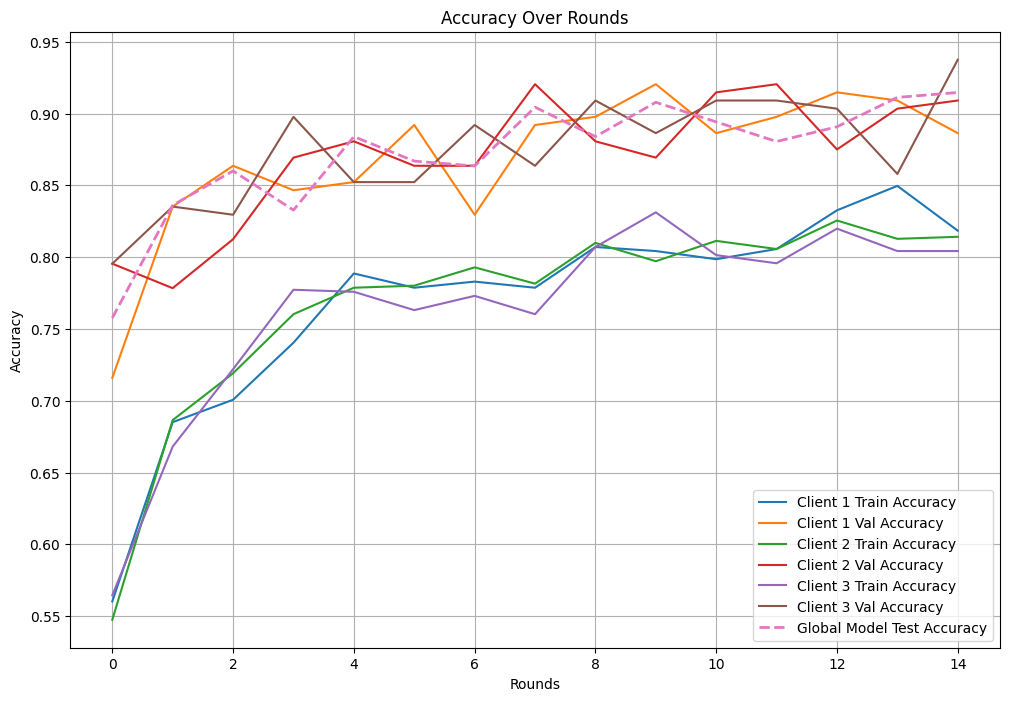

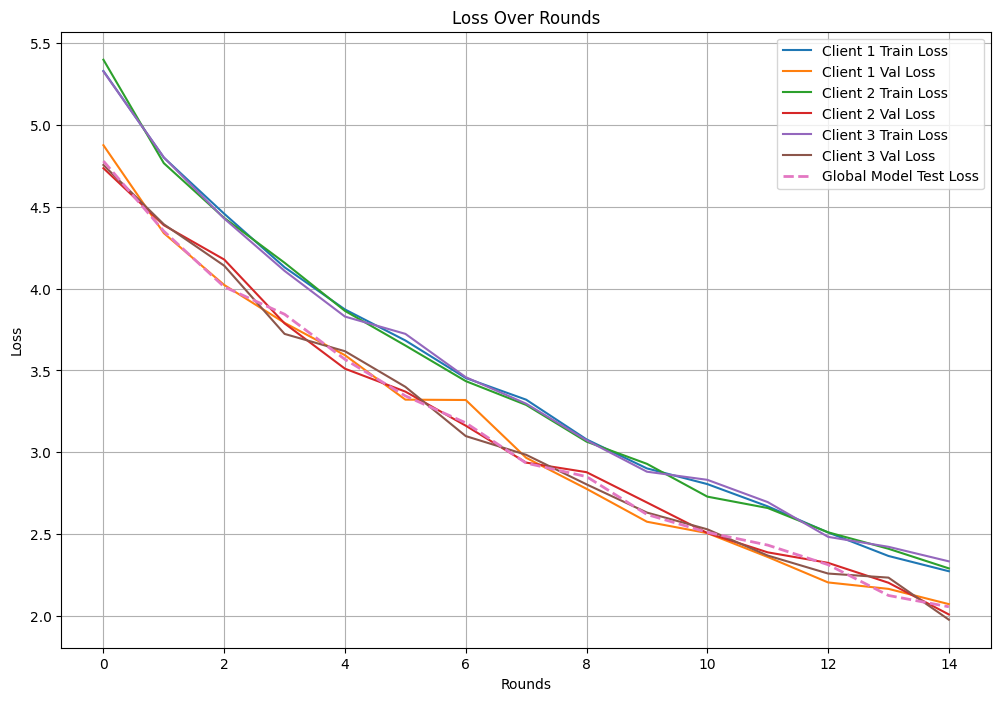

In [10]:
# Plotting the results
plt.figure(figsize=(12, 8))

# Plotting Train and Validation accuracy for each client
for i in range(num_clients):
    plt.plot(client_metrics['train_accuracy'][i], label=f'Client {i+1} Train Accuracy')
    plt.plot(client_metrics['val_accuracy'][i], label=f'Client {i+1} Val Accuracy')

# Plotting Global model test accuracy
plt.plot(global_accuracies, label='Global Model Test Accuracy', linestyle='--', linewidth=2)
plt.title('Accuracy Over Rounds')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
# Plotting Train and Validation loss for each client
for i in range(num_clients):
    plt.plot(client_metrics['train_loss'][i], label=f'Client {i+1} Train Loss')
    plt.plot(client_metrics['val_loss'][i], label=f'Client {i+1} Val Loss')
# Plotting Global model test loss
plt.plot(global_losses, label='Global Model Test Loss', linestyle='--', linewidth=2)
plt.title('Loss Over Rounds')
plt.xlabel('Rounds')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


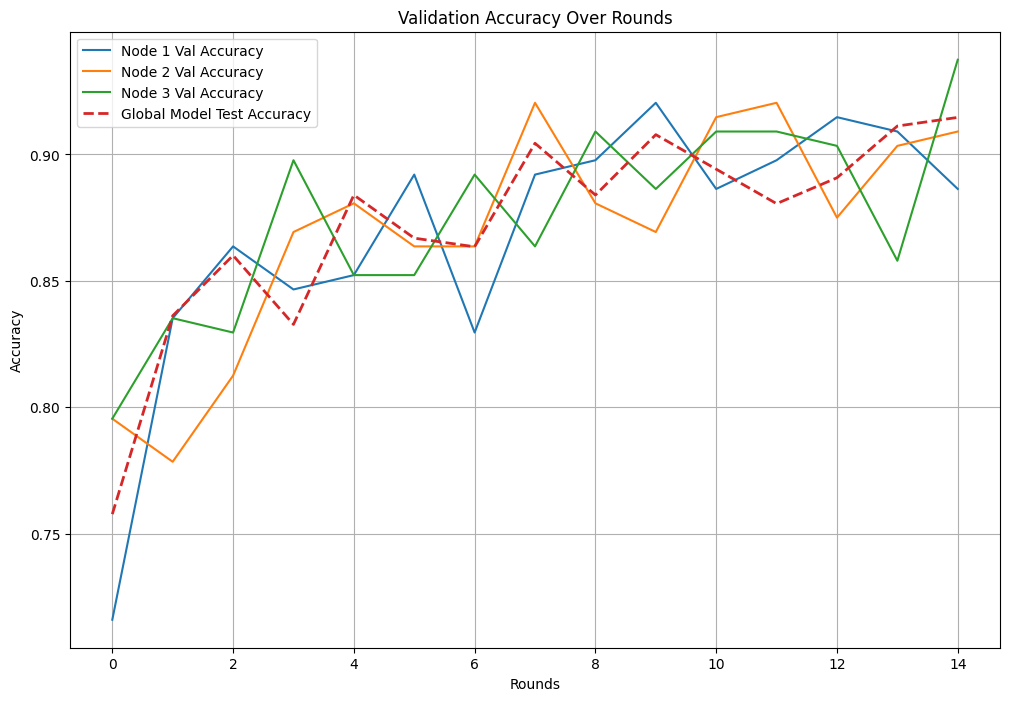

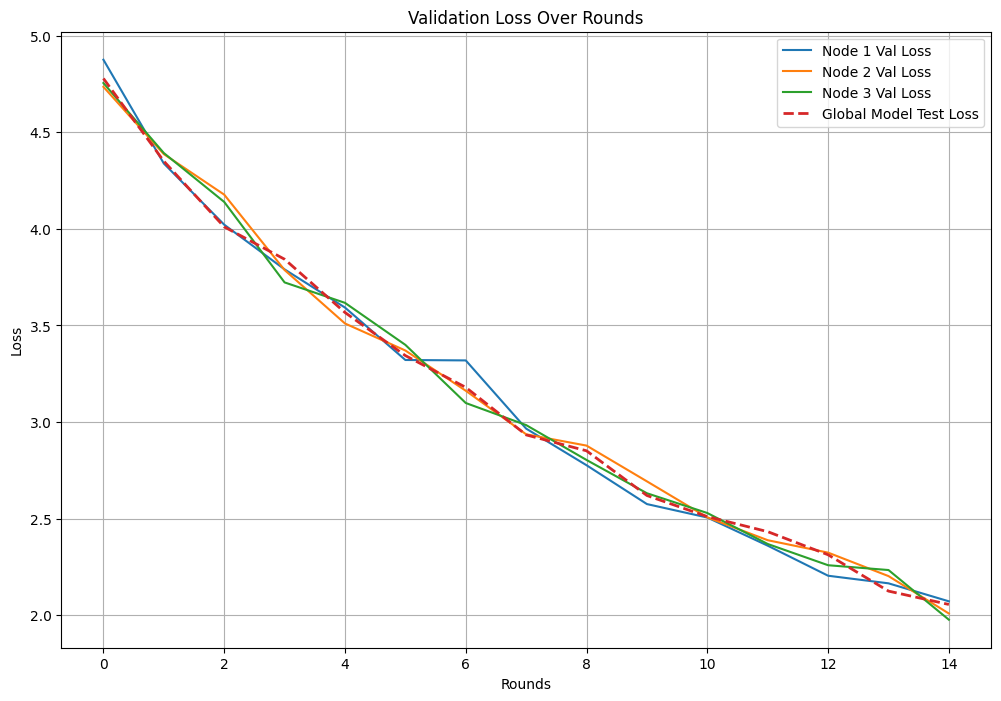

In [11]:
# Plot for Validation Accuracy
plt.figure(figsize=(12, 8))
for i in range(num_clients):
    plt.plot(client_metrics['val_accuracy'][i], label=f'Node {i + 1} Val Accuracy')
plt.plot(global_accuracies, label='Global Model Test Accuracy', linestyle='--', linewidth=2)
plt.title('Validation Accuracy Over Rounds')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot for Validation Loss
plt.figure(figsize=(12, 8))
for i in range(num_clients):
    plt.plot(client_metrics['val_loss'][i], label=f'Node {i + 1} Val Loss')
plt.plot(global_losses, label='Global Model Test Loss', linestyle='--', linewidth=2)
plt.title('Validation Loss Over Rounds')
plt.xlabel('Rounds')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

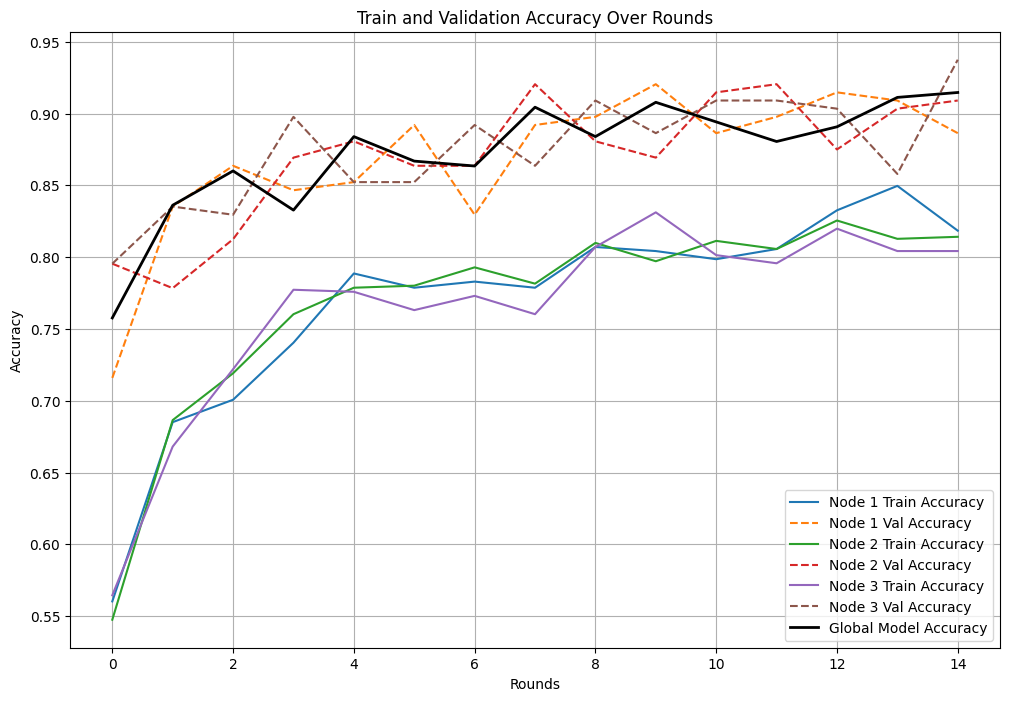

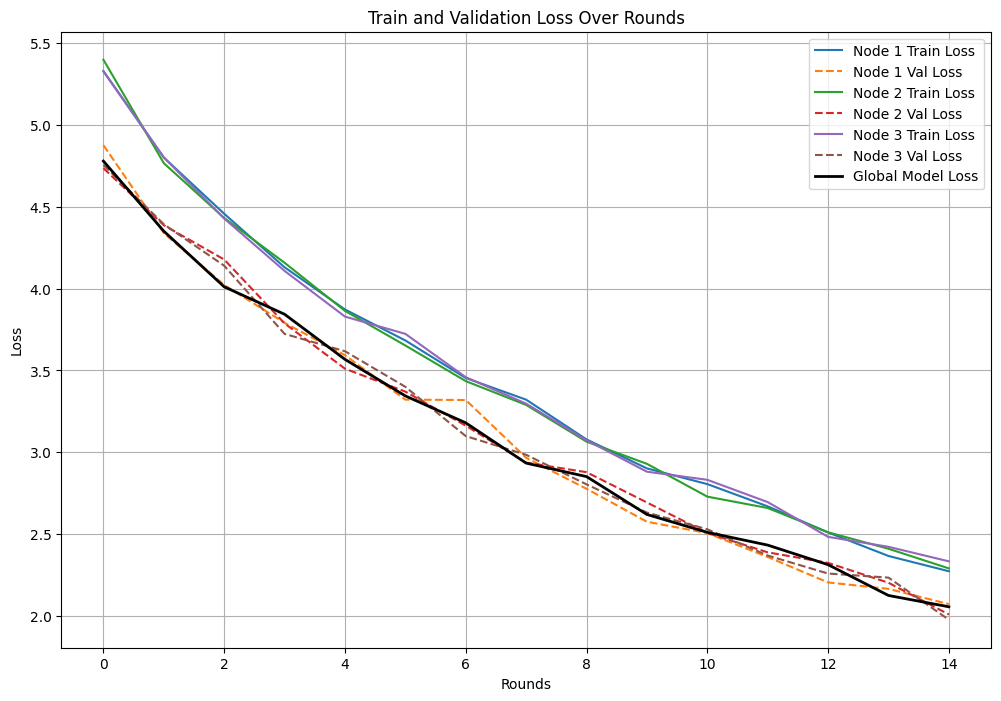

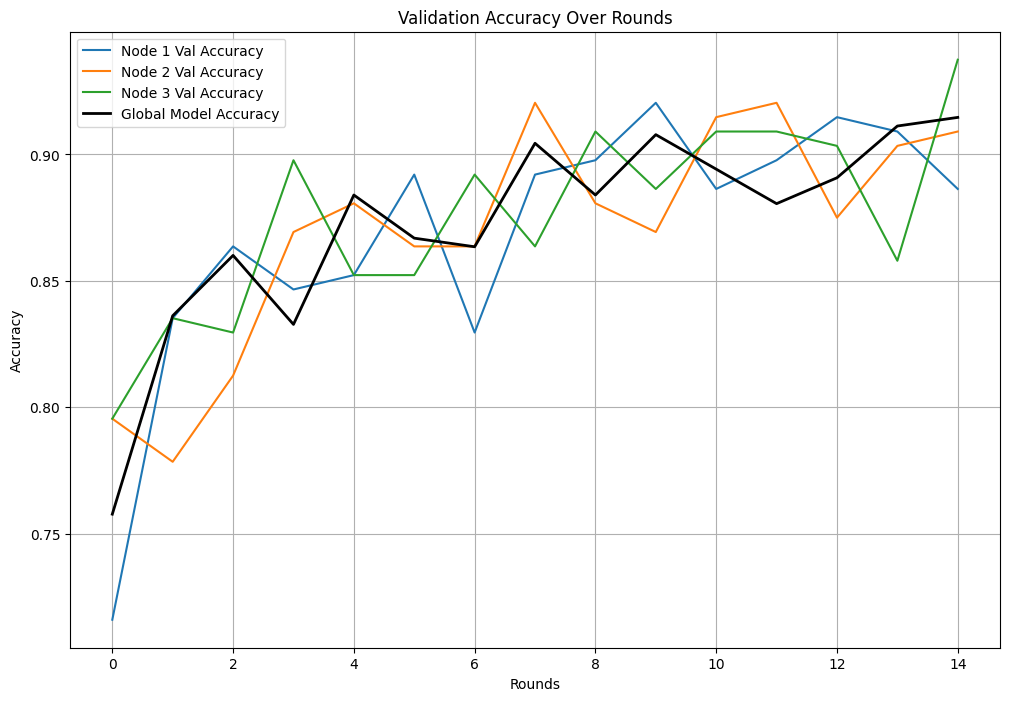

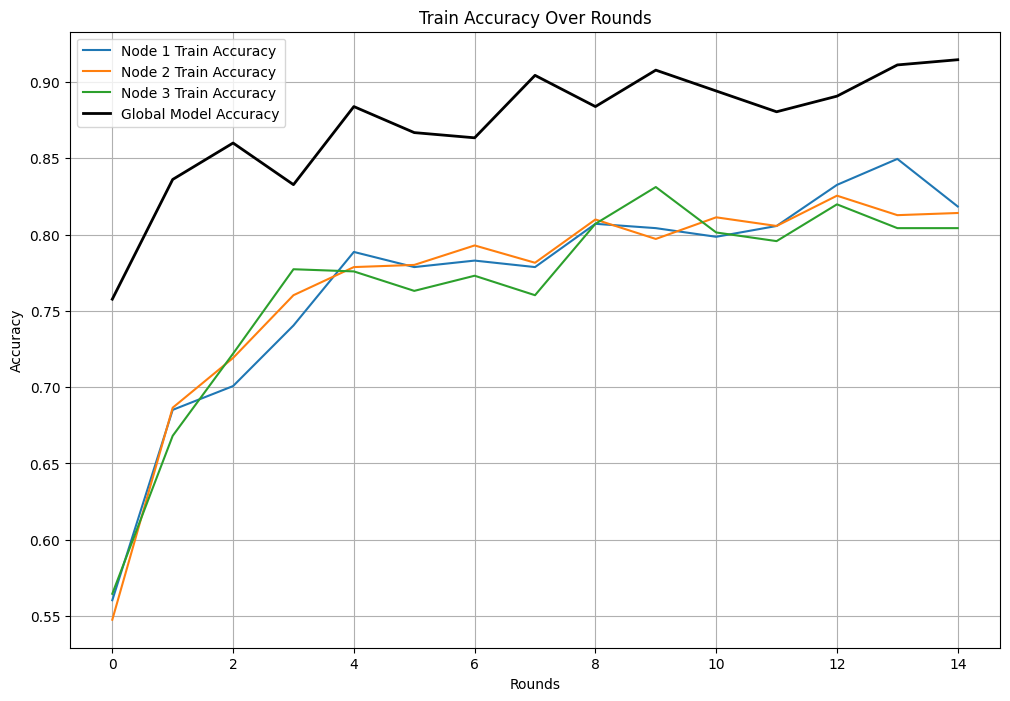

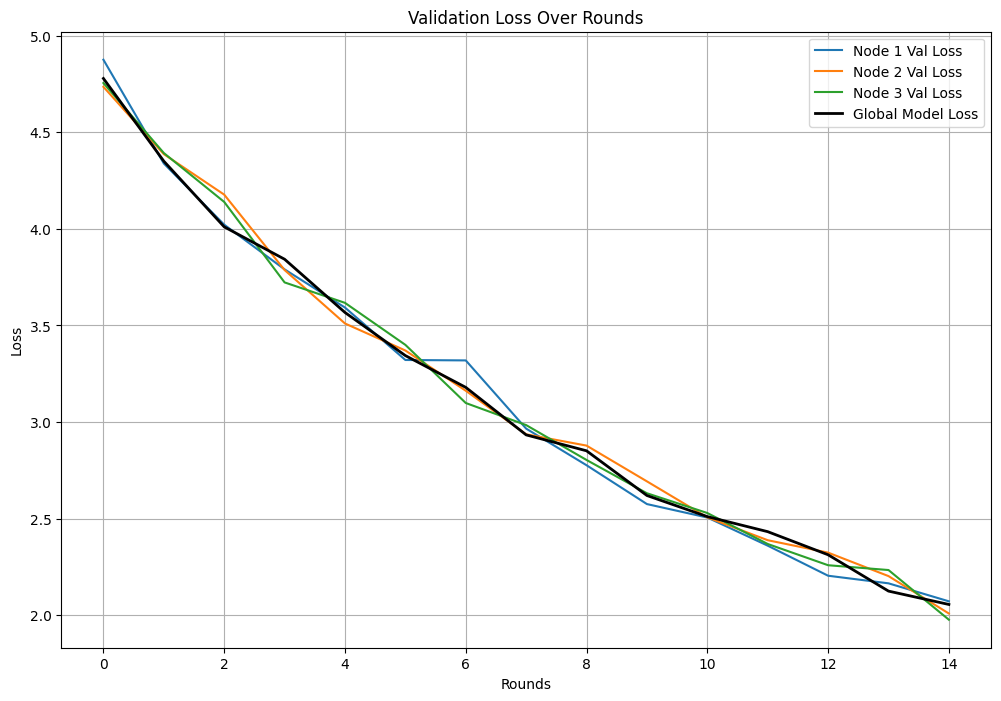

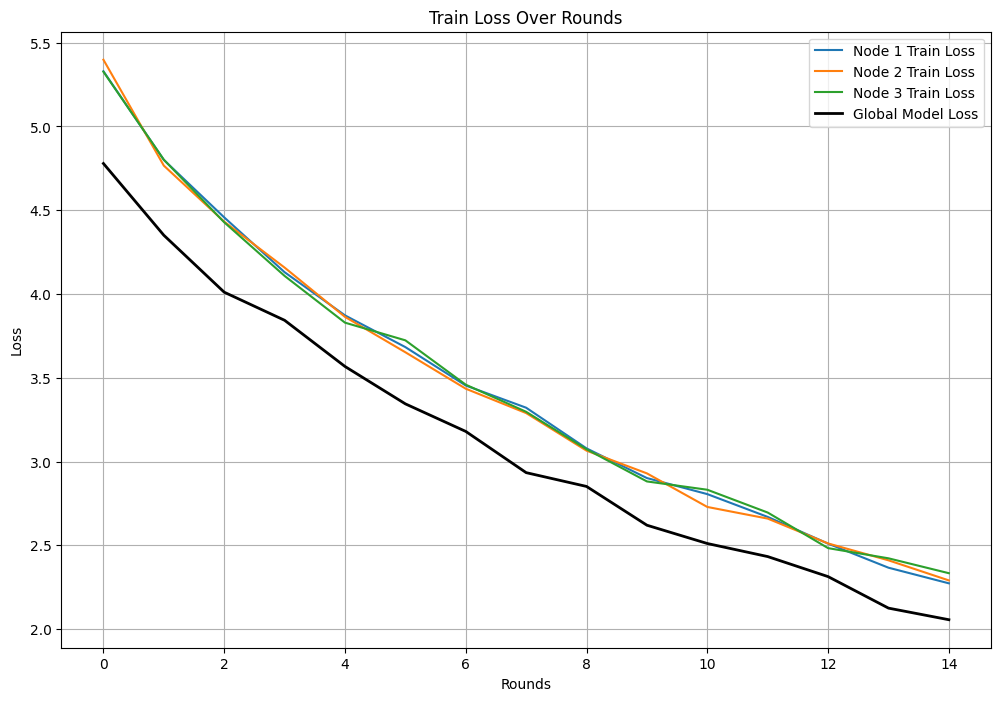

In [12]:
# Plot 1: Train and Validation Accuracy for each client and the global model
plt.figure(figsize=(12, 8))
for i in range(num_clients):
    plt.plot(client_metrics['train_accuracy'][i], label=f'Node {i+1} Train Accuracy')
    plt.plot(client_metrics['val_accuracy'][i], label=f'Node {i+1} Val Accuracy', linestyle='--')
plt.plot(global_accuracies, label='Global Model Accuracy', linestyle='-', linewidth=2, color='black')
plt.title('Train and Validation Accuracy Over Rounds')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Train and Validation Loss for each client and the global model
plt.figure(figsize=(12, 8))
for i in range(num_clients):
    plt.plot(client_metrics['train_loss'][i], label=f'Node {i+1} Train Loss')
    plt.plot(client_metrics['val_loss'][i], label=f'Node {i+1} Val Loss', linestyle='--')
plt.plot(global_losses, label='Global Model Loss', linestyle='-', linewidth=2, color='black')
plt.title('Train and Validation Loss Over Rounds')
plt.xlabel('Rounds')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot 3: Validation Accuracy for each client and the global model
plt.figure(figsize=(12, 8))
for i in range(num_clients):
    plt.plot(client_metrics['val_accuracy'][i], label=f'Node {i+1} Val Accuracy')
plt.plot(global_accuracies, label='Global Model Accuracy', linestyle='-', linewidth=2, color='black')
plt.title('Validation Accuracy Over Rounds')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot 4: Train Accuracy for each client and the global model
plt.figure(figsize=(12, 8))
for i in range(num_clients):
    plt.plot(client_metrics['train_accuracy'][i], label=f'Node {i+1} Train Accuracy')
plt.plot(global_accuracies, label='Global Model Accuracy', linestyle='-', linewidth=2, color='black')
plt.title('Train Accuracy Over Rounds')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot 5: Validation Loss for each client and the global model
plt.figure(figsize=(12, 8))
for i in range(num_clients):
    plt.plot(client_metrics['val_loss'][i], label=f'Node {i+1} Val Loss')
plt.plot(global_losses, label='Global Model Loss', linestyle='-', linewidth=2, color='black')
plt.title('Validation Loss Over Rounds')
plt.xlabel('Rounds')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot 6: Train Loss for each client and the global model
plt.figure(figsize=(12, 8))
for i in range(num_clients):
    plt.plot(client_metrics['train_loss'][i], label=f'Node {i+1} Train Loss')
plt.plot(global_losses, label='Global Model Loss', linestyle='-', linewidth=2, color='black')
plt.title('Train Loss Over Rounds')
plt.xlabel('Rounds')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

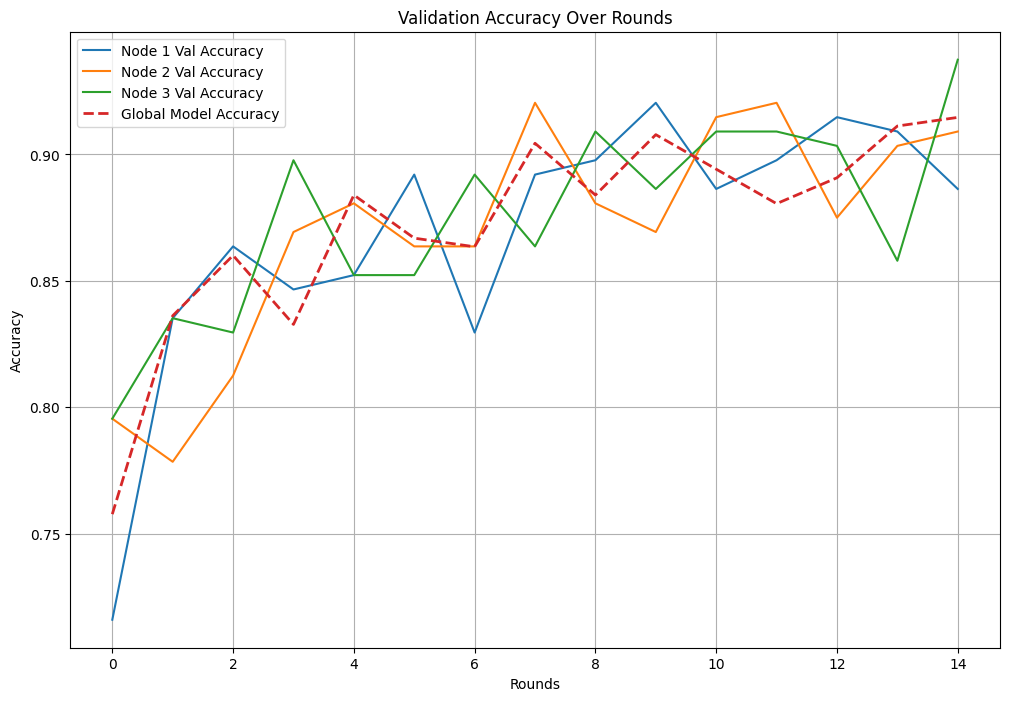

In [13]:
# Plotting Validation Accuracy for Each Client and Global Model
plt.figure(figsize=(12, 8))

# Validation Accuracies for each client
for i in range(num_clients):
    plt.plot(client_metrics['val_accuracy'][i], label=f'Node {i+1} Val Accuracy')

# Global Model Accuracy
plt.plot(global_accuracies, label='Global Model Accuracy', linestyle='--', linewidth=2)

plt.title('Validation Accuracy Over Rounds')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

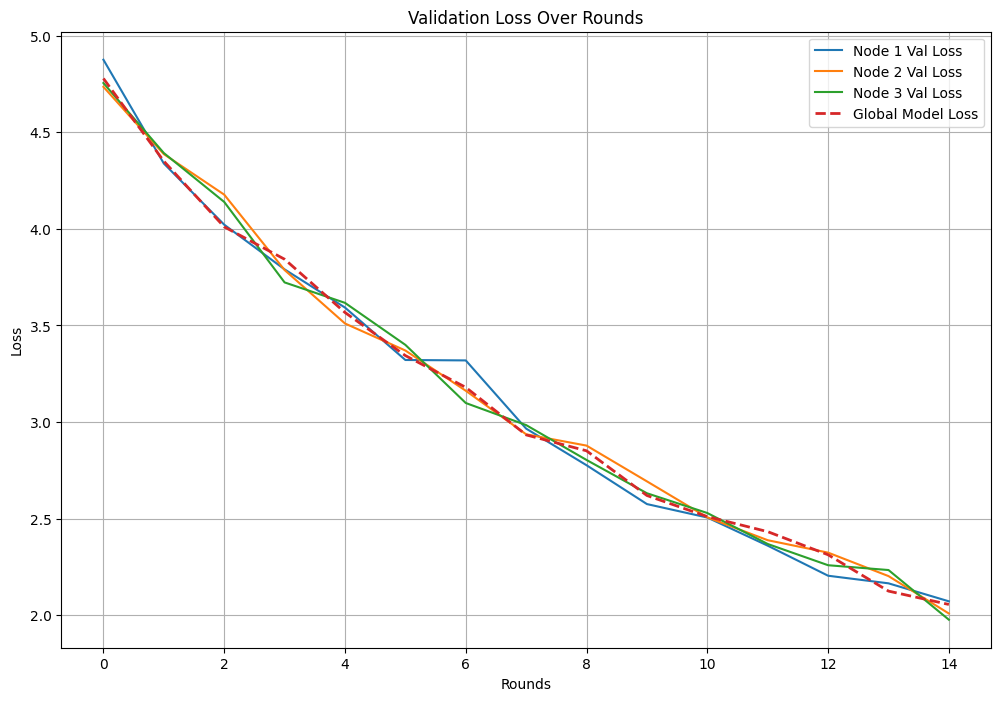

In [14]:
# Plotting Validation Loss for Each Client and Global Model
plt.figure(figsize=(12, 8))

# Validation Losses for each client
for i in range(num_clients):
    plt.plot(client_metrics['val_loss'][i], label=f'Node {i+1} Val Loss')

# Global Model Loss
plt.plot(global_losses, label='Global Model Loss', linestyle='--', linewidth=2)

plt.title('Validation Loss Over Rounds')
plt.xlabel('Rounds')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

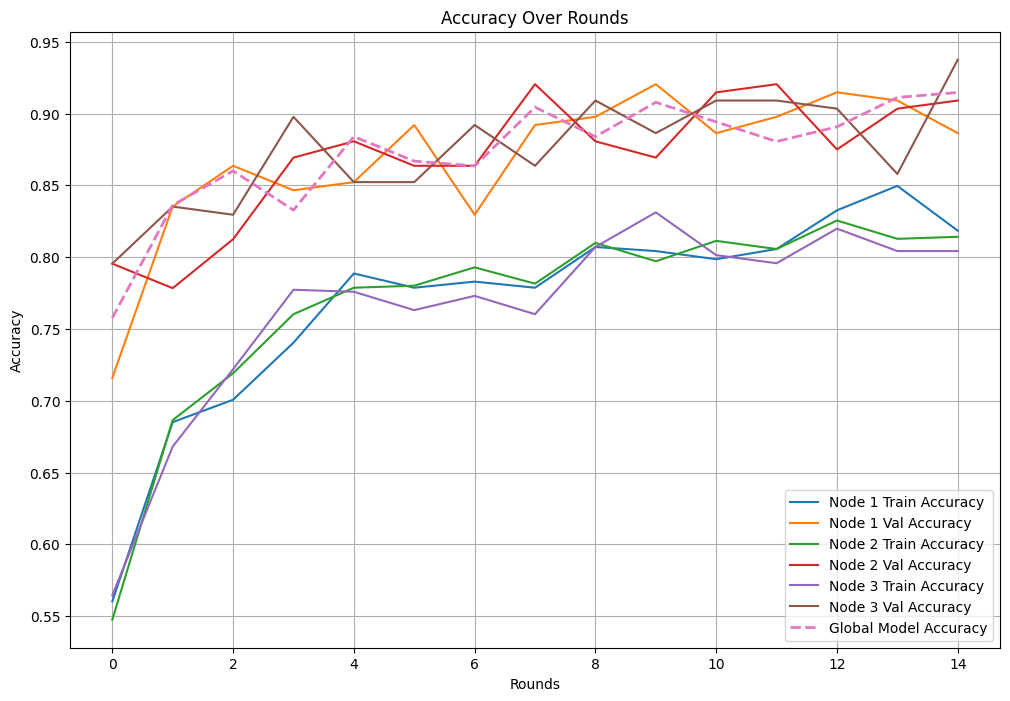

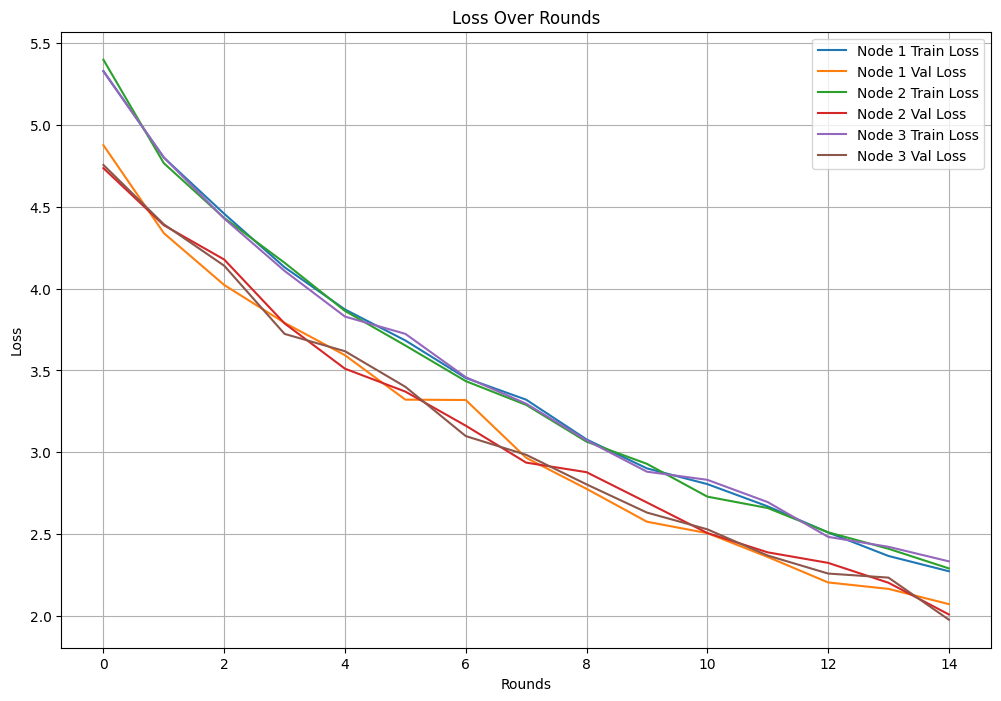

In [15]:
# Plotting
plt.figure(figsize=(12, 8))
for i in range(num_clients):
    plt.plot(client_metrics['train_accuracy'][i], label=f'Node {i+1} Train Accuracy')
    plt.plot(client_metrics['val_accuracy'][i], label=f'Node {i+1} Val Accuracy')
plt.plot(global_accuracies, label='Global Model Accuracy', linestyle='--', linewidth=2)
plt.title('Accuracy Over Rounds')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
for i in range(num_clients):
    plt.plot(client_metrics['train_loss'][i], label=f'Node {i+1} Train Loss')
    plt.plot(client_metrics['val_loss'][i], label=f'Node {i+1} Val Loss')
plt.title('Loss Over Rounds')
plt.xlabel('Rounds')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

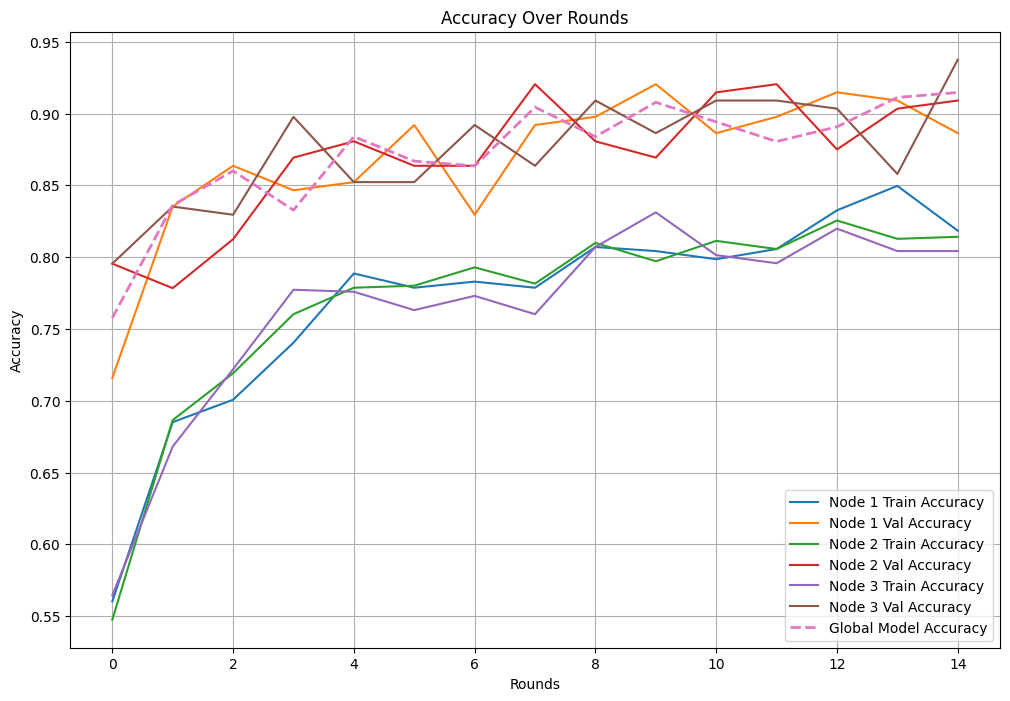

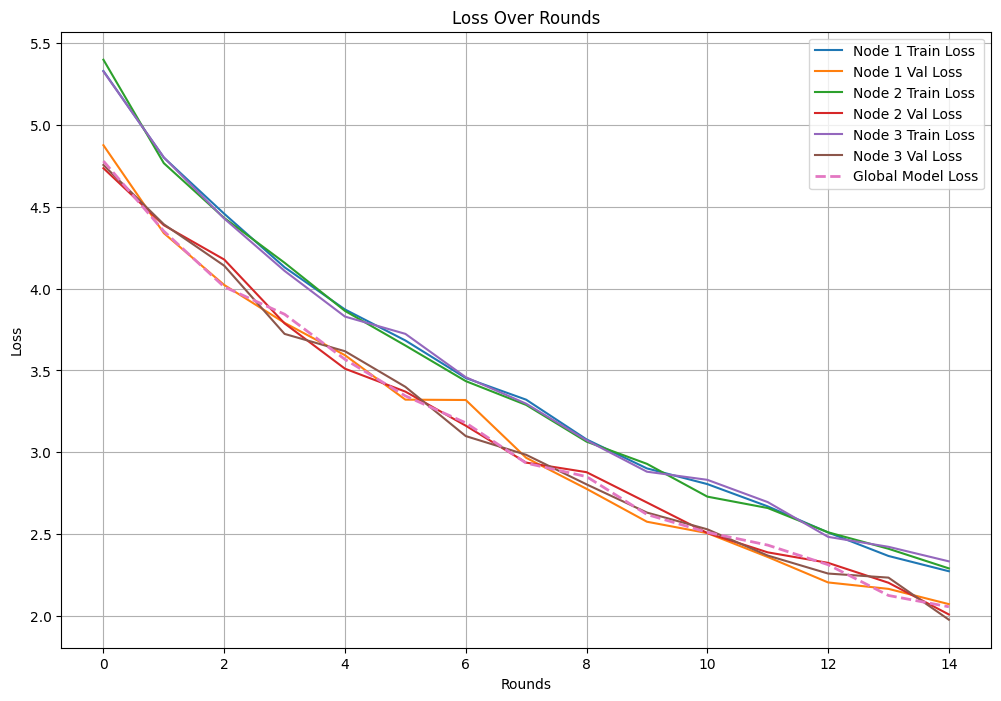

In [16]:
# Plotting
plt.figure(figsize=(12, 8))

# Train and Validation Accuracies for each client
for i in range(num_clients):
    plt.plot(client_metrics['train_accuracy'][i], label=f'Node {i+1} Train Accuracy')
    plt.plot(client_metrics['val_accuracy'][i], label=f'Node {i+1} Val Accuracy')

# Global Model Accuracy
plt.plot(global_accuracies, label='Global Model Accuracy', linestyle='--', linewidth=2)

plt.title('Accuracy Over Rounds')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Train and Validation Losses for each client
plt.figure(figsize=(12, 8))

for i in range(num_clients):
    plt.plot(client_metrics['train_loss'][i], label=f'Node {i+1} Train Loss')
    plt.plot(client_metrics['val_loss'][i], label=f'Node {i+1} Val Loss')

# Global Model Loss
plt.plot(global_losses, label='Global Model Loss', linestyle='--', linewidth=2)

plt.title('Loss Over Rounds')
plt.xlabel('Rounds')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

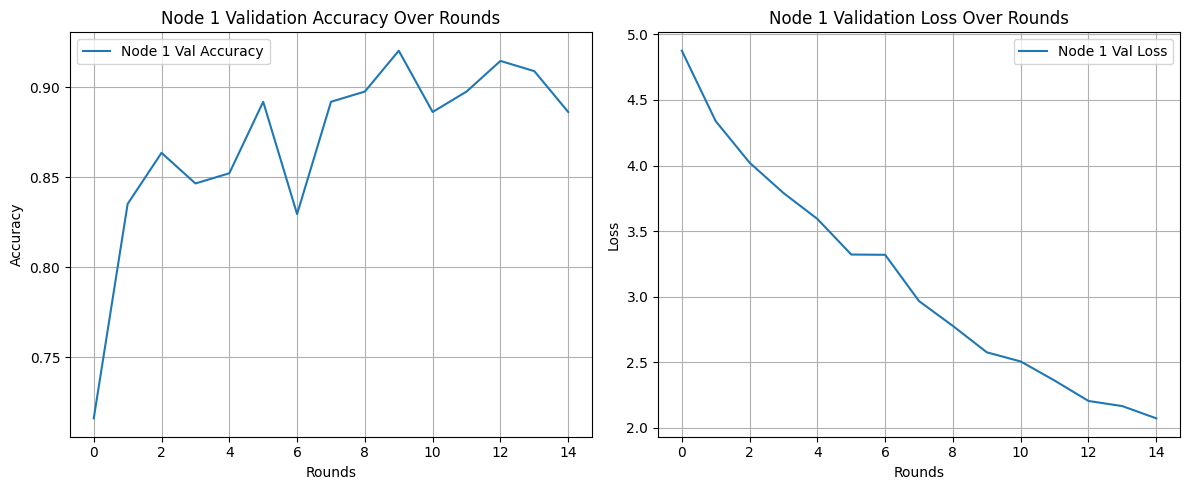

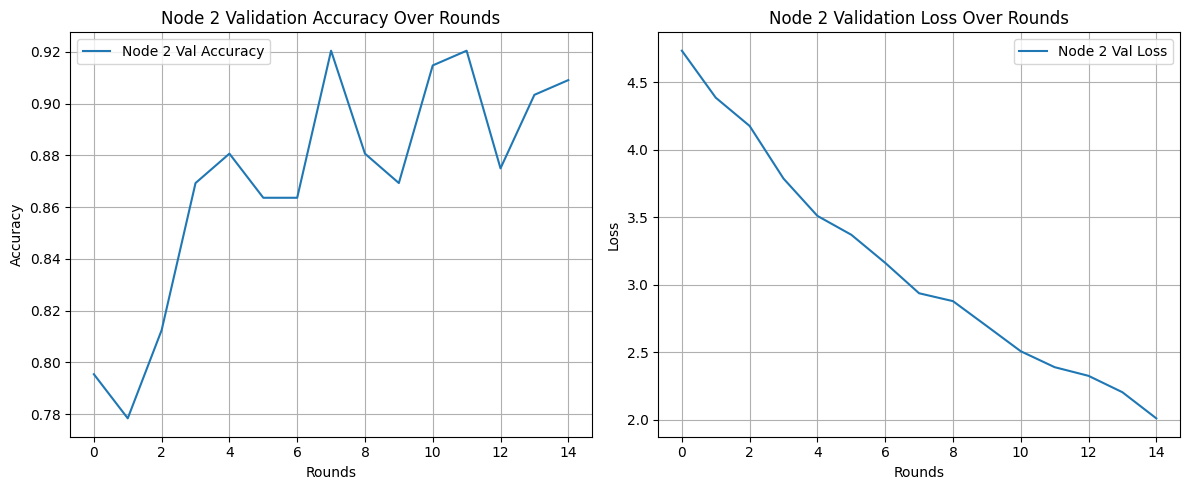

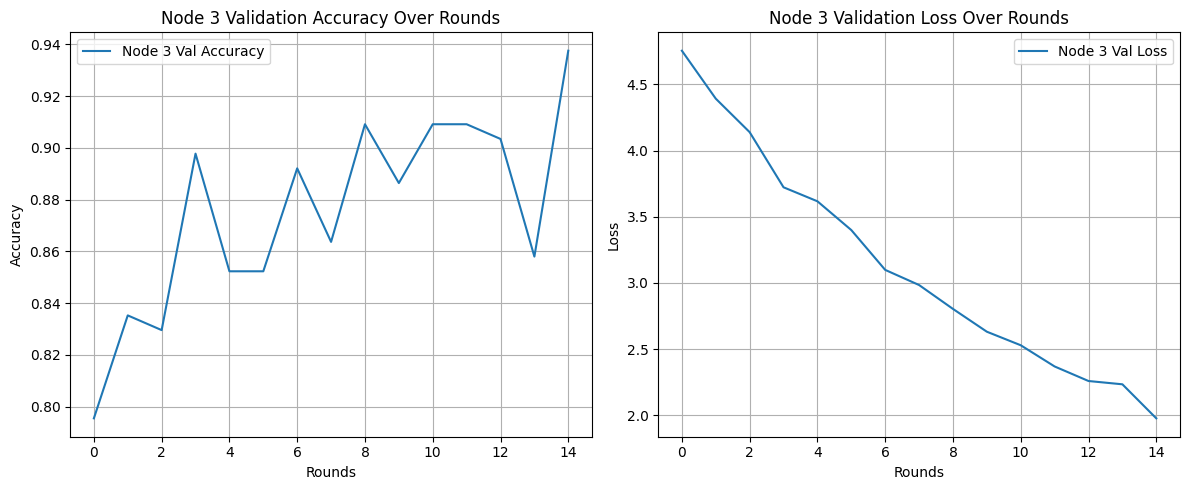

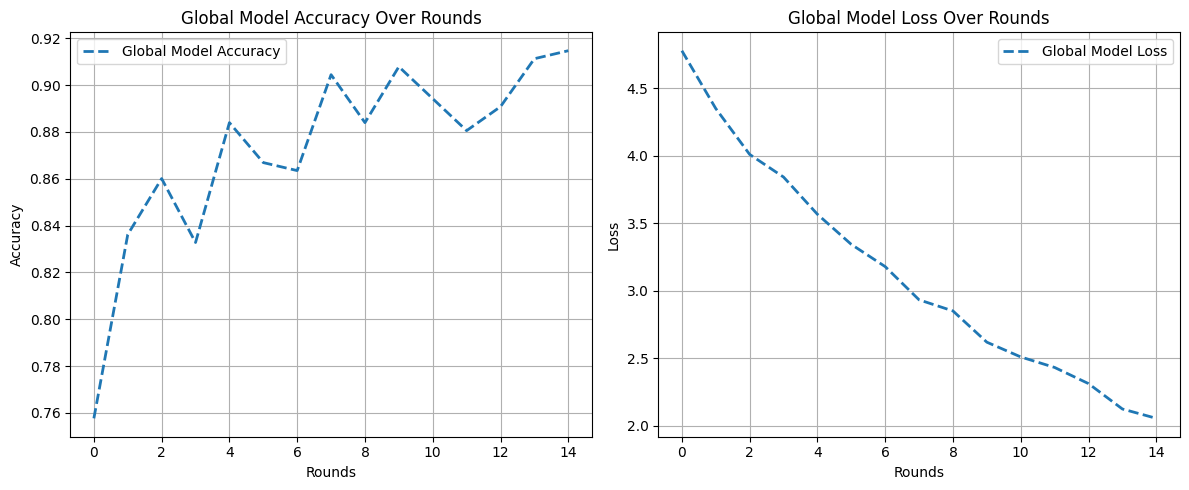

In [17]:
#Plotting individual node and global model metrics

import matplotlib.pyplot as plt

# Plot for Validation Accuracy and Loss for each client and the global model
for i in range(num_clients):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Create a figure with two subplots

    # Validation Accuracy for the current client
    axs[0].plot(client_metrics['val_accuracy'][i], label=f'Node {i + 1} Val Accuracy')
    axs[0].set_title(f'Node {i + 1} Validation Accuracy Over Rounds')
    axs[0].set_xlabel('Rounds')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()
    axs[0].grid(True)

    # Validation Loss for the current client
    axs[1].plot(client_metrics['val_loss'][i], label=f'Node {i + 1} Val Loss')
    axs[1].set_title(f'Node {i + 1} Validation Loss Over Rounds')
    axs[1].set_xlabel('Rounds')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()  # Adjust subplot parameters for a tight layout
    plt.show()  # Display the figure


# Plot for Global Model Accuracy and Loss
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Create a figure with two subplots

# Global Model Accuracy
axs[0].plot(global_accuracies, label='Global Model Accuracy', linestyle='--', linewidth=2)
axs[0].set_title('Global Model Accuracy Over Rounds')
axs[0].set_xlabel('Rounds')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# Global Model Loss
axs[1].plot(global_losses, label='Global Model Loss', linestyle='--', linewidth=2)
axs[1].set_title('Global Model Loss Over Rounds')
axs[1].set_xlabel('Rounds')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()  # Adjust subplot parameters for a tight layout
plt.show()  # Display the figure

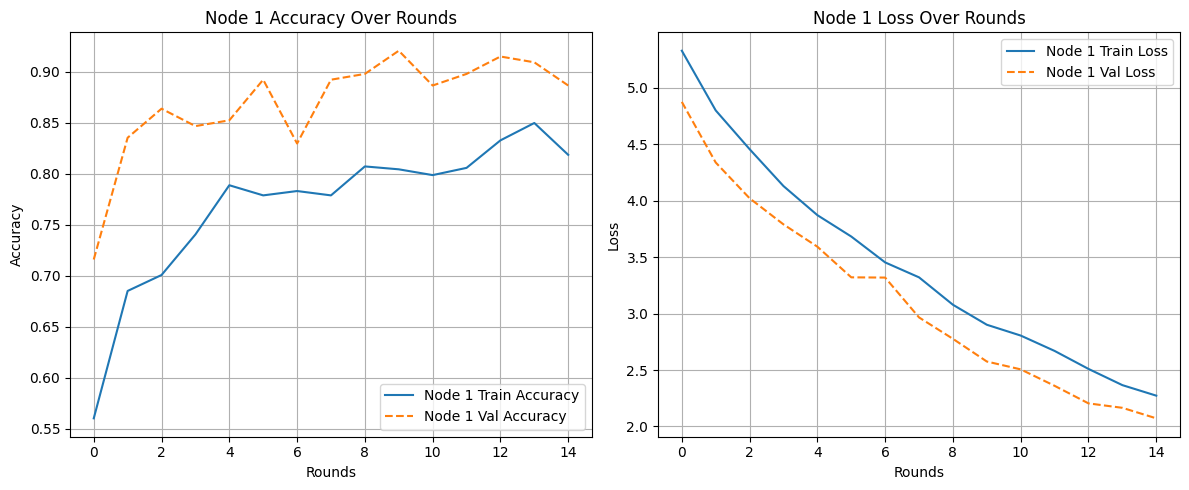

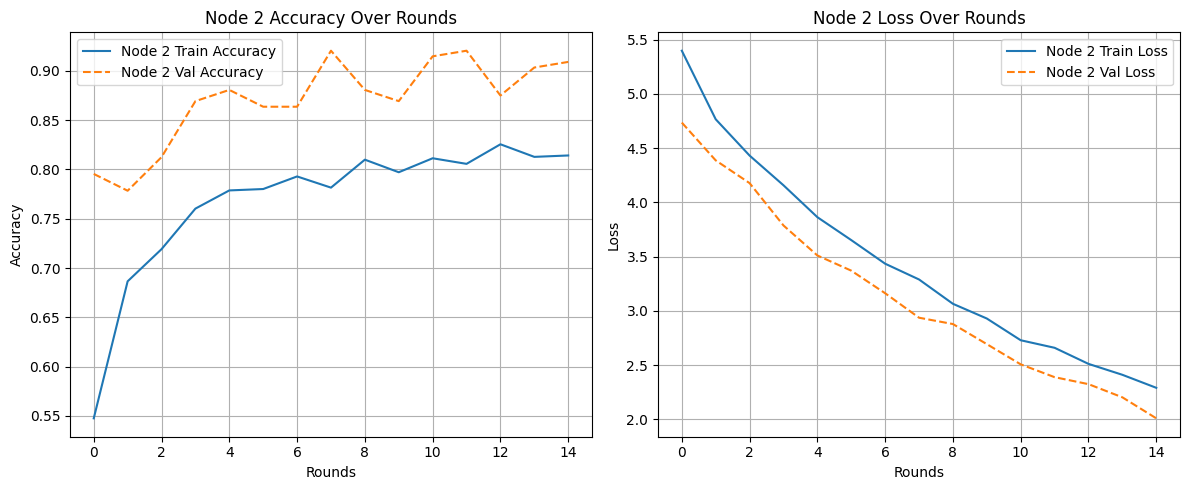

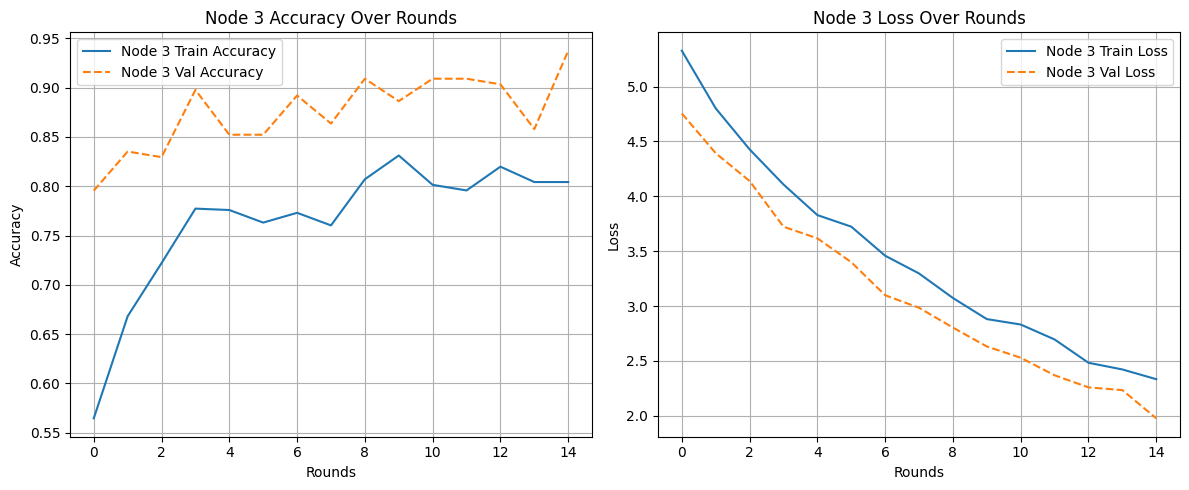

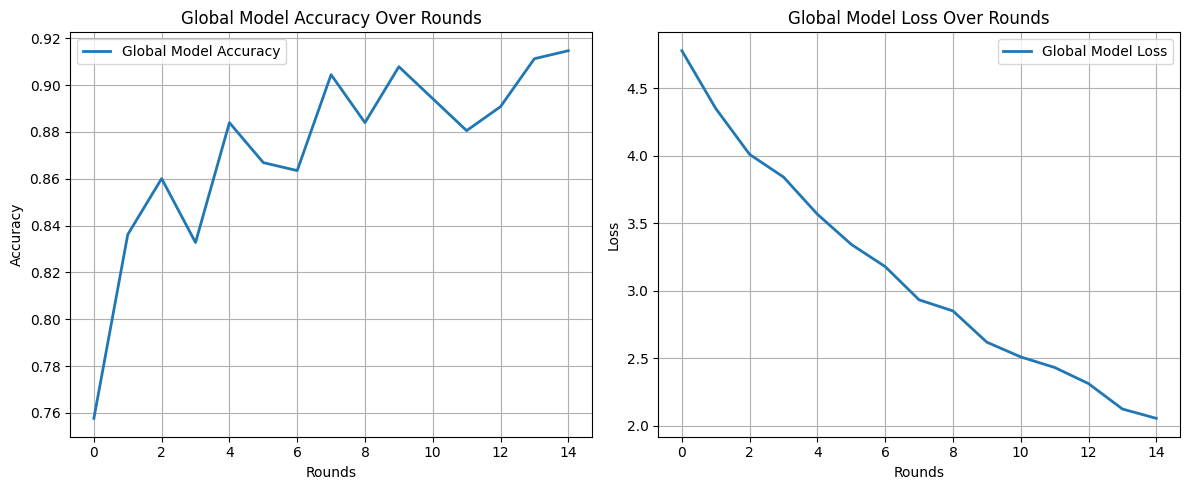

In [18]:
#Plotting individual node and global model metrics

import matplotlib.pyplot as plt

# Plot for each client (node)
for i in range(num_clients):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Create a figure with two subplots

    # Accuracy subplot for the current client
    axs[0].plot(client_metrics['train_accuracy'][i], label=f'Node {i + 1} Train Accuracy')
    axs[0].plot(client_metrics['val_accuracy'][i], label=f'Node {i + 1} Val Accuracy', linestyle='--')
    axs[0].set_title(f'Node {i + 1} Accuracy Over Rounds')
    axs[0].set_xlabel('Rounds')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()
    axs[0].grid(True)

    # Loss subplot for the current client
    axs[1].plot(client_metrics['train_loss'][i], label=f'Node {i + 1} Train Loss')
    axs[1].plot(client_metrics['val_loss'][i], label=f'Node {i + 1} Val Loss', linestyle='--')
    axs[1].set_title(f'Node {i + 1} Loss Over Rounds')
    axs[1].set_xlabel('Rounds')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()  # Adjust subplot parameters for a tight layout
    plt.show()  # Display the figure

# Plot for Global Model Accuracy and Loss
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Create a figure with two subplots

# Global Model Accuracy
axs[0].plot(global_accuracies, label='Global Model Accuracy', linestyle='-', linewidth=2)
axs[0].set_title('Global Model Accuracy Over Rounds')
axs[0].set_xlabel('Rounds')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# Global Model Loss
axs[1].plot(global_losses, label='Global Model Loss', linestyle='-', linewidth=2)
axs[1].set_title('Global Model Loss Over Rounds')
axs[1].set_xlabel('Rounds')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()  # Adjust subplot parameters for a tight layout
plt.show()  # Display the figure

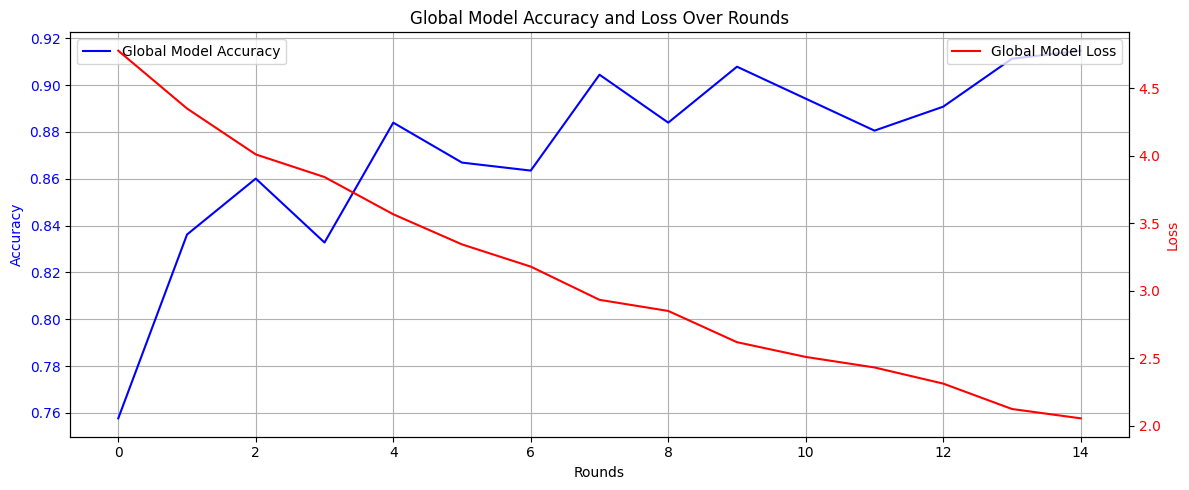

In [19]:
#Plotting global model metrics

import matplotlib.pyplot as plt

# Plot for Global Model Accuracy and Loss
fig, ax1 = plt.subplots(figsize=(12, 5))  # Create a single figure

# Global Model Accuracy (using ax1)
ax1.plot(global_accuracies, label='Global Model Accuracy', color='blue')
ax1.set_xlabel('Rounds')
ax1.set_ylabel('Accuracy', color='blue')
ax1.tick_params('y', labelcolor='blue')
ax1.legend(loc='upper left')
ax1.grid(True)

# Create a second y-axis for Loss (ax2)
ax2 = ax1.twinx()

# Global Model Loss (using ax2)
ax2.plot(global_losses, label='Global Model Loss', color='red')
ax2.set_ylabel('Loss', color='red')
ax2.tick_params('y', labelcolor='red')
ax2.legend(loc='upper right')

plt.title('Global Model Accuracy and Loss Over Rounds')
plt.tight_layout()  # Adjust layout for better visualization
plt.show()  # Display the figure